In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import sparse, stats
from sklearn.model_selection import KFold

from pynba import possessions_from_file, use_blackontrans_style

%load_ext pyinstrument

use_blackontrans_style()
league = "nba"
years = [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
season_type = "Regular Season"

possessions = pd.concat([possessions_from_file(league, year, season_type) for year in years])
nba_player_ids = pd.read_csv("/home/jupyter/nba/data/NBA_Player_IDs.csv", encoding_errors="ignore")
player_id_mapping = {
    int(player_id): player_name
    for player_name, player_id
    in zip(nba_player_ids["NBAName"], nba_player_ids["NBAID"])
    if not pd.isna(player_id)
}

In [2]:
POSS_COLS = [
    "off_player0", "off_player1", "off_player2", "off_player3", "off_player4", 
    "def_player0", "def_player1", "def_player2", "def_player3", "def_player4",
    "points_scored", "possession_num", "date"
]


def calc_rapm(possessions, half_life, off_prior, def_prior):
    stints = _calc_stints(possessions)
    player_ids = _calc_player_ids(stints)
    n_players = player_ids.shape[0]
    X = _calc_X(stints, player_ids, n_players)
    w = _calc_w(stints, half_life)
    XT_W = _calc_XT_W(X, w)
    y = stints["y"].to_numpy()
    G = _calc_G(XT_W, stints, off_prior, def_prior, n_players)
    A, b = _calc_A_b(X, XT_W, G, y)
    x = _solve_for_x(A, b)
    
    rapm, off_rapm, def_rapm = _calc_rapm(x, n_players)
    rapm_std, off_rapm_std, def_rapm_std = _calc_stds(X, x, y, w, A, n_players)
    off_poss, def_poss, raw_pm, off_raw_pm, def_raw_pm = _calc_raw_stats(XT_W, b, n_players)
    names = _calc_names(player_ids)
    return pd.DataFrame({
        "name": names,
        "rapm": rapm,
        "off_rapm": off_rapm,
        "def_rapm": def_rapm,
        "rapm_std": rapm_std,
        "off_rapm_std": off_rapm_std,
        "def_rapm_std": def_rapm_std,
        "off_poss": off_poss,
        "def_poss": def_poss,
        "raw_pm": raw_pm,
        "off_raw_pm": off_raw_pm,
        "def_raw_pm": def_raw_pm,
    }, index=player_ids)


def _calc_player_ids(stints):
    cols = [f"off_player{ind}" for ind in range(5)] + [f"def_player{ind}" for ind in range(5)]
    return np.unique(stints.loc[:, cols])


def _calc_stints(possessions):
    poss = possessions.loc[:, POSS_COLS]
    off_player_ids = poss[[f"off_player{ind}" for ind in range(5)]].to_numpy()
    off_player_ids.sort(1)
    poss["off_player_ids"] = [row.tobytes() for row in off_player_ids]
    def_player_ids = poss[[f"def_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids.sort(1)
    poss["def_player_ids"] = [row.tobytes() for row in def_player_ids]
    stints = poss.groupby(by=["date", "off_player_ids", "def_player_ids"]).agg(
        {
            "off_player0": "first",
            "off_player1": "first",
            "off_player2": "first",
            "off_player3": "first",
            "off_player4": "first",
            "def_player0": "first",
            "def_player1": "first",
            "def_player2": "first",
            "def_player3": "first",
            "def_player4": "first",
            "points_scored": "sum",
            "possession_num": "count",
        }
    ).reset_index()
    stints["days_ago"] = _calc_days_ago(stints["date"])
    stints.sort_values("date", inplace=True)
    del stints["off_player_ids"], stints["def_player_ids"]
    stints["mu"], stints["sigma"] = _calc_mu_sigma(possessions, stints)
    stints["y"] = (stints["points_scored"] / stints["possession_num"] * 100 - stints["mu"])
    return stints.reset_index(drop=True)


def _calc_days_ago(dates):
    dates = pd.DatetimeIndex(dates)
    return (dates.max() - dates).days.to_numpy().astype(float)


def _calc_X(stints, player_ids, n_players):
    off_player_ids = stints.loc[:, [f"off_player{ind}" for ind in range(5)]].to_numpy()
    def_player_ids = stints.loc[:, [f"def_player{ind}" for ind in range(5)]].to_numpy()
    n_stints = stints.shape[0]

    X = sparse.lil_matrix((2 * n_players, n_stints))
    for ind, player_id in enumerate(player_ids):
        X[ind, :] = (player_id == off_player_ids).any(1)
        X[n_players + ind, :] = (player_id == def_player_ids).any(1)

    return X.T.tocsr().astype("float64")


def _calc_mu_sigma(possessions, stints):
    alpha = np.exp(np.log(0.5) / 20)
    alpha_4 = np.exp(np.log(0.5) / 100)
    points_df = possessions.groupby(["points_scored", "date"]).agg(count=("off_team_id", "count")).reset_index()
    points_df["days_ago"] = _calc_days_ago(points_df["date"])
    days = points_df["days_ago"].unique()
    points = [1, 2, 3]
    df_dict = {point: [] for point in points + [4]}

    filts = {point: points_df["points_scored"] == point for point in points + [4]}
    
    for day in days:
        weights = (alpha ** np.abs(points_df["days_ago"] - day)) * points_df["count"]
        divisor = weights.sum()
        for point in points:
            est = weights[filts[point]].sum() / divisor
            df_dict[point].append(est)

    for day in days:
        weights = (alpha_4 ** np.abs(points_df["days_ago"] - day)) * points_df["count"]
        divisor = weights.sum()
        est = weights[filts[4]].sum() / divisor
        df_dict[4].append(est)

    df = pd.DataFrame(df_dict, index=days)
    unique_pts = points_df["points_scored"].unique()
    other_pts = unique_pts[unique_pts > 4]
    for point in other_pts:
        df[point] = points_df.loc[points_df["points_scored"] == point, "count"].sum() / points_df["count"].sum()

    df[0] = 1 - df.sum(1)

    df["mu"] = sum([df[point] * point * 100 for point in unique_pts])
    df["var"] = sum([df[point] * (point * 100) ** 2 for point in unique_pts]) - df["mu"] ** 2
    mu = stints["days_ago"].map(df["mu"])
    sigma = np.sqrt(stints["days_ago"].map(df["var"]) / stints["possession_num"])
    return mu, sigma


def _calc_w(stints, half_life):
    alpha = np.exp(np.log(0.5) / (half_life * 365.25))
    days_ago = stints["days_ago"] - stints["days_ago"].min()
    w = stints["possession_num"] * alpha ** days_ago
    return w.to_numpy().astype("float64").reshape(-1, 1)


def _calc_XT_W(X, w):
    return X.multiply(w).T.tocsr()


def _calc_G(XT_W, stints, off_prior, def_prior, n_players):
    normalizer = np.asarray(XT_W.sum(1)).reshape(-1)
    no_samples = normalizer == 0
    normalizer[no_samples] = 1
    variances = XT_W.dot(stints["sigma"] ** 2 * stints["possession_num"]) / normalizer
    variances[no_samples] = stints["sigma"].iloc[-1] ** 2 * stints["possession_num"].iloc[-1]
    diagonal = variances / np.array([off_prior ** 2] * n_players + [def_prior ** 2] * n_players)
    return sparse.diags(diagonal)


def _calc_A_b(X, XT_W, G, y):
    A = XT_W.dot(X) + G
    b = XT_W.dot(y)
    return A, b


def _solve_for_x(A, b):
    return sparse.linalg.spsolve(A, b)


def _calc_rapm(x, n_players):
    off_rapm, def_rapm = x[:n_players], -x[n_players:]
    rapm = off_rapm + def_rapm
    return rapm, off_rapm, def_rapm


def _calc_stds(X, x, y, w, A, n_players):
    r = y - X.dot(x)
    rss = (r * w.reshape(-1)).dot(r)
    sigma2 = rss / (X.shape[0] - X.shape[1])
    cov_x = sigma2 * sparse.linalg.inv(A.tocsc())
    x_var = cov_x.diagonal()
    off_def_cov = cov_x.diagonal(n_players)
    off_rapm_var, def_rapm_var = x_var[:n_players], x_var[n_players:]
    rapm_var = off_rapm_var + def_rapm_var + 2 * off_def_cov
    return np.sqrt(rapm_var), np.sqrt(off_rapm_var), np.sqrt(def_rapm_var)


def _calc_raw_stats(XT_W, b, n_players):
    poss = np.asarray(XT_W.sum(1)).reshape(-1)
    off_poss, def_poss = poss[:n_players], poss[n_players:]
    raw_pms = b / poss
    off_raw_pm, def_raw_pm = raw_pms[:n_players], -raw_pms[n_players:]
    raw_pm = off_raw_pm + def_raw_pm
    return off_poss, def_poss, raw_pm, off_raw_pm, def_raw_pm


def _calc_names(player_ids):
    return [player_id_mapping.get(player_id, "n/a") for player_id in player_ids]

## Optimizing the prior using pattern search

Cutting the search space in half takes 1.5 evaluations (we're assuming the search space is convex).

In [3]:
def optimize_rapm(possessions, rounds, half_life_range, off_prior_range, def_prior_range):
    stints = _calc_stints(possessions)
    player_ids = _calc_player_ids(stints)
    n_players = player_ids.shape[0]
    X = _calc_X(stints, player_ids, n_players)
    def objective(half_life, off_prior, def_prior):
        return _score_rapm(X, stints, n_players, half_life, off_prior, def_prior)
    return _pattern_search(objective, rounds, half_life_range, off_prior_range, def_prior_range)


def _score_rapm(X, stints, n_players, half_life, off_prior, def_prior):
    logpdf = 0
    size = X.shape[0]
    chunk_size = 1_000
    start = size * 5 // 10
    for train_index, test_index in _chunked_ts_cv(size, chunk_size, start):
        X_train = X[train_index]
        stints_train = stints.iloc[train_index, :]
        y_train = stints_train["y"].to_numpy()
        w_train = _calc_w(stints_train, half_life)
        XT_W_train = _calc_XT_W(X_train, w_train)
        G_train = _calc_G(XT_W_train, stints_train, off_prior, def_prior, n_players)
        A_train, b_train = _calc_A_b(X_train, XT_W_train, G_train, y_train)
        x = _solve_for_x(A_train, b_train)

        X_test = X[test_index]
        stints_test = stints.iloc[test_index, :]
        y_test = stints_test["y"].to_numpy()
        sigma_test = stints_test["sigma"].to_numpy()
        normalized_test_err = (y_test - X_test.dot(x)) / sigma_test
        logpdf += stats.norm.logpdf(normalized_test_err).sum()
    return logpdf


def _chunked_ts_cv(size, chunk_size, start):
    while (stop:= start + chunk_size) < size:
        yield np.arange(start), np.arange(start, stop)
        start = stop
    yield np.arange(start), np.arange(start, size)


def _pattern_search(func, rounds, *args):
    bounds = np.array([[arg[0], arg[1]] for arg in args]).astype(float)
    x1 = bounds.mean(1)
    y1 = func(*x1)
    steps = np.diff(bounds, 1).reshape(-1) / 4
    history = [(tuple(x1), y1)]
    for _ in range(rounds):
        for ind, step in enumerate(steps):
            x0 = x1.copy()
            x0[ind] -= step
            y0 = func(*x0)
            history.append((tuple(x0), y0))
            if y0 > y1:
                bounds[ind, 1] = x1[ind]
                x1, y1 = x0, y0
                continue
            x2 = x1.copy()
            x2[ind] += step
            y2 = func(*x2)
            history.append((tuple(x2), y2))
            if y2 > y1:
                bounds[ind, 0] = x1[ind]
                x1, y1 = x2, y2
            else:
                bounds[ind, 0] = x0[ind]
                bounds[ind, 1] = x2[ind]
        steps /= 2
    return tuple(x1), y1, bounds, history

In [4]:
off_prior_range = (2, 3)
def_prior_range = (2, 3)
half_life_range = (1, 2)
rounds = 6
%pyinstrument best_inputs, lowest_score, best_range, history = optimize_rapm(possessions, rounds, half_life_range, off_prior_range, def_prior_range)

_     ._   __/__   _ _  _  _ _/_   Recorded: 08:13:43  Samples:  938849
 /_//_/// /_\ / //_// / //_'/ //     Duration: 51463.132 CPU time: 293816.551
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-9563597e-c580-4a35-8598-c6786a00cdb7.json

51463.131 <module>  ../../../tmp/ipykernel_237/3463932052.py:2
`- 51463.127 optimize_rapm  ../../../tmp/ipykernel_237/3286253205.py:1
   `- 51320.380 _pattern_search  ../../../tmp/ipykernel_237/3286253205.py:42
      `- 51320.380 objective  ../../../tmp/ipykernel_237/3286253205.py:6
         `- 51320.177 _score_rapm  ../../../tmp/ipykernel_237/3286253205.py:11
            |- 33604.155 _solve_for_x  ../../../tmp/ipykernel_237/3030414316.py:161
            |  `- 33604.155 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
            |        [13 frames hidden]  scipy, <built-in>
            |           32674.067 gssv  <built-in>:0
            |- 11199.300 _calc_A_b  ../../../tmp/ipykernel_237/3030414316.py:155
            |  `- 11085.124 dot  scipy/sparse/base.py:346
            |        [45 frames hidden]  scipy, <built-in>, <__array_function_...
            |- 3590.069 _calc_XT_W  ../../../tmp/ipykernel_237/3030414316.py:141
            |  |- 2196.916 multiply  scipy/sparse/compressed.py:365
            |  |     [83 frames hidden]  scipy, numpy, <built-in>, abc, <__arr...
            |  `- 877.039 tocsr  scipy/sparse/coo.py:372
            |        [13 frames hidden]  scipy, <built-in>
            |- 1072.371 __getitem__  pandas/core/indexing.py:918
            |     [413 frames hidden]  pandas, <built-in>, numpy, contextlib
            |- 656.557 __getitem__  scipy/sparse/_index.py:32
            |     [123 frames hidden]  scipy, <built-in>, <__array_function_...
            `- 634.986 _calc_w  ../../../tmp/ipykernel_237/3030414316.py:134
               `- 519.642 __array_ufunc__  pandas/core/generic.py:2029
                     [99 frames hidden]  pandas, <built-in>, numpy

In [5]:
best_inputs

(1.359375, 2.6875, 2.3046875)

In [6]:
best_range

array([[1.3515625, 1.3671875],
       [2.6796875, 2.6953125],
       [2.296875 , 2.3125   ]])

In [7]:
history

[((1.5, 2.5, 2.5), -815927.6660771879),
 ((1.25, 2.5, 2.5), -815928.7813013652),
 ((1.75, 2.5, 2.5), -815933.3189655766),
 ((1.5, 2.25, 2.5), -815937.529103916),
 ((1.5, 2.75, 2.5), -815927.0683606951),
 ((1.5, 2.75, 2.25), -815924.4942497199),
 ((1.375, 2.75, 2.25), -815923.1377307785),
 ((1.375, 2.625, 2.25), -815923.0640693624),
 ((1.375, 2.625, 2.125), -815924.9492820497),
 ((1.375, 2.625, 2.375), -815923.216820762),
 ((1.3125, 2.625, 2.25), -815923.4687075169),
 ((1.4375, 2.625, 2.25), -815923.225464768),
 ((1.375, 2.5625, 2.25), -815923.7616836458),
 ((1.375, 2.6875, 2.25), -815922.8698939065),
 ((1.375, 2.6875, 2.1875), -815923.5342300428),
 ((1.375, 2.6875, 2.3125), -815922.7140660185),
 ((1.34375, 2.6875, 2.3125), -815922.7188904034),
 ((1.40625, 2.6875, 2.3125), -815922.8467040214),
 ((1.375, 2.65625, 2.3125), -815922.749566416),
 ((1.375, 2.71875, 2.3125), -815922.7942244173),
 ((1.375, 2.6875, 2.28125), -815922.7309521241),
 ((1.375, 2.6875, 2.34375), -815922.8144009904),
 

In [8]:
half_life, off_prior, def_prior = best_half_life
%pyinstrument rapm = calc_rapm(possessions, half_life, off_prior, def_prior)

rapm.sort_values(by="rapm", ascending=False).head(30)

/tmp/ipykernel_237/3030414316.py:186: RuntimeWarning: invalid value encountered in true_divide
  raw_pms = b / poss


_     ._   __/__   _ _  _  _ _/_   Recorded: 22:39:02  Samples:  25084
 /_//_/// /_\ / //_// / //_'/ //     Duration: 170.400   CPU time: 200.089
/   _/                      v4.1.1

Program: /home/jupyter/.venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/jupyter/.local/share/jupyter/runtime/kernel-9563597e-c580-4a35-8598-c6786a00cdb7.json

170.399 <module>  ../../../tmp/ipykernel_237/2642818445.py:2
`- 170.396 calc_rapm  ../../../tmp/ipykernel_237/3030414316.py:8
   |- 125.668 _calc_X  ../../../tmp/ipykernel_237/3030414316.py:82
   |  |- 110.540 __setitem__  scipy/sparse/lil.py:323
   |  |     [30 frames hidden]  scipy, <built-in>, <__array_function_...
   |  |        106.335 lil_fancy_set  <built-in>:0
   |  |- 9.793 [self]  
   |  `- 5.151 __getattr__  scipy/sparse/base.py:673
   |        [23 frames hidden]  scipy, <built-in>
   |- 24.765 _calc_stds  ../../../tmp/ipykernel_237/3030414316.py:171
   |  `- 24.649 inv  scipy/sparse/linalg/matfuncs.py:33
   |        [53 frames hidden]  scipy, <built-in>, numpy, <__array_fu...
   |- 15.905 _calc_stints  ../../../tmp/ipykernel_237/3030414316.py:45
   |  |- 6.316 _calc_mu_sigma  ../../../tmp/ipykernel_237/3030414316.py:95
   |  |  `- 4.246 __array_ufunc__  pandas/core/generic.py:2029
   |  |        [352 frames hidden]  pandas, <built-in>, numpy, abc
   |  `- 5.010 aggregate  pandas/core/groupby/generic.py:964
   |        [151 frames hidden]  pandas, <built-in>, <__array_function...
   `- 2.198 _solve_for_x  ../../../tmp/ipykernel_237/3030414316.py:161
      `- 2.198 spsolve  scipy/sparse/linalg/dsolve/linsolve.py:91
            [9 frames hidden]  scipy, <built-in>

,name,rapm,off_rapm,def_rapm,rapm_std,off_rapm_std,def_rapm_std,off_poss,def_poss,raw_pm,off_raw_pm,def_raw_pm
201939,Stephen Curry,9.590598,7.841909,1.748689,0.712441,0.520739,0.486823,10693.269242,10720.404088,14.247674,10.990418,3.257257
101108,Chris Paul,6.985362,3.892185,3.093177,0.646106,0.468942,0.444944,9072.240003,9100.322733,10.570725,7.380157,3.190568
2544,LeBron James,6.702408,5.556778,1.145630,0.613255,0.445304,0.423179,11320.534797,11316.943666,4.637706,5.532780,-0.895073
201950,Jrue Holiday,6.554678,3.515065,3.039613,0.665572,0.485071,0.457514,10828.414034,10848.752568,3.254568,2.585922,0.668646
200768,Kyle Lowry,6.322547,4.653691,1.668855,0.668646,0.487477,0.459167,10636.081125,10617.458479,8.191351,6.343771,1.847581
203081,Damian Lillard,5.939916,4.525692,1.414225,0.688371,0.502008,0.471224,12306.153573,12322.769358,5.646522,5.097190,0.549331
202331,Paul George,5.926758,2.435092,3.491666,0.631429,0.459403,0.434959,12234.621469,12240.633516,5.760537,2.547422,3.213114
203954,Joel Embiid,5.906509,2.540111,3.366397,0.751650,0.550601,0.513542,6600.517020,6607.059269,7.825627,3.459954,4.365673
203999,Nikola Jokic,5.844052,4.514064,1.329987,0.730644,0.535669,0.499536,9185.010218,9204.280246,5.386140,5.973165,-0.587025
201935,James Harden,5.623925,5.947697,-0.323772,0.646805,0.470646,0.444000,12689.193187,12687.311239,6.575075,7.221758,-0.646683


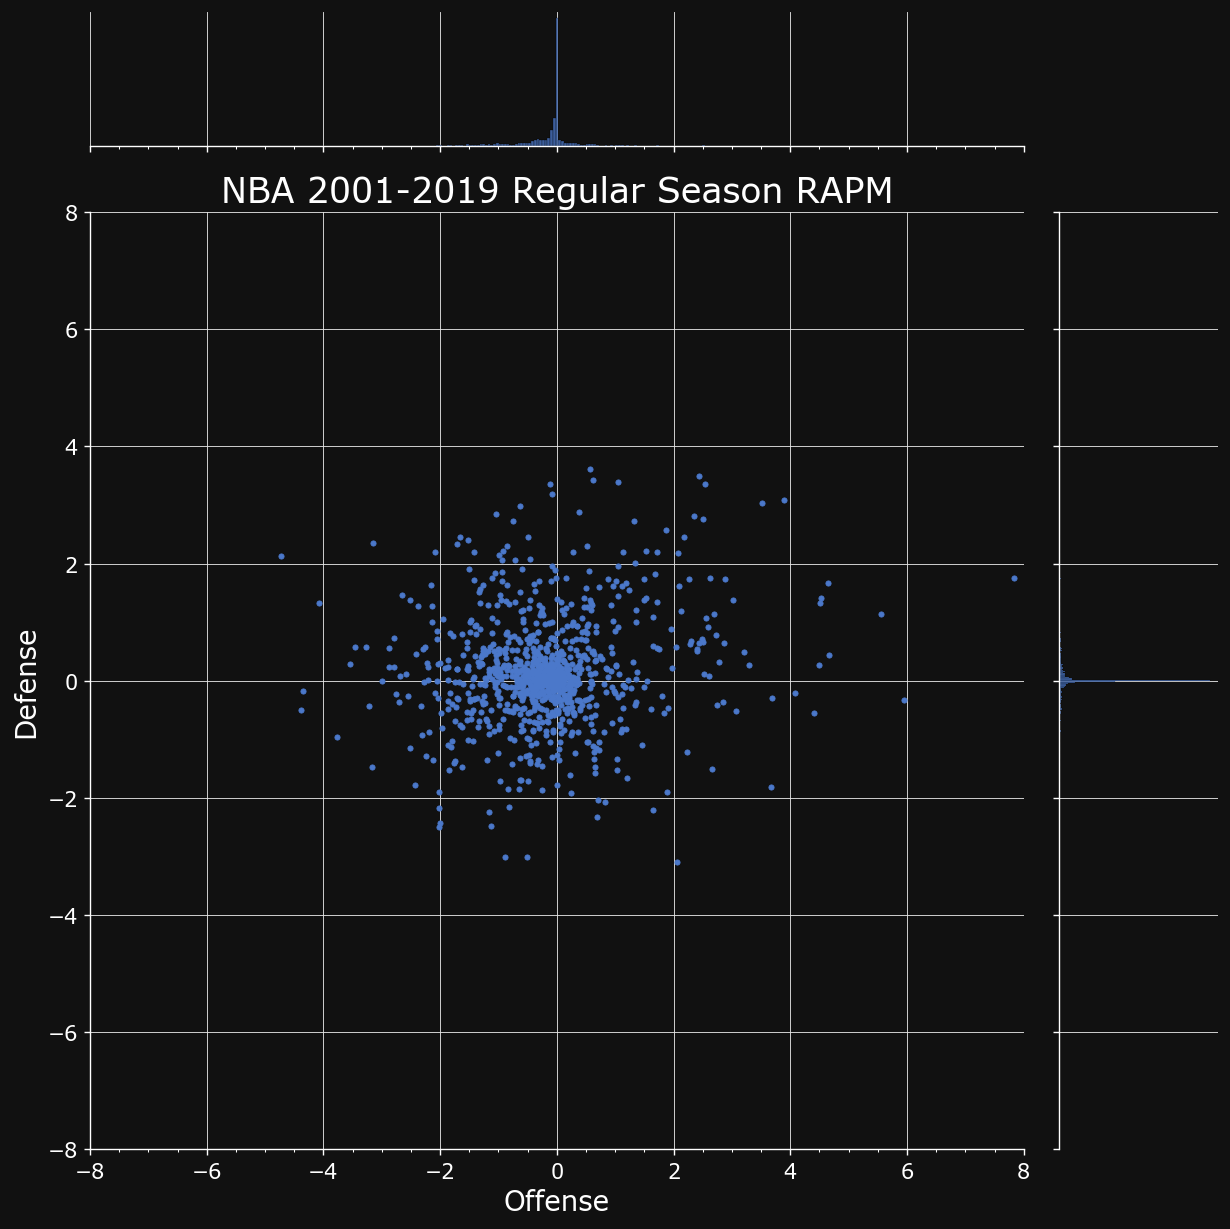

In [9]:
lim = max(np.ceil(rapm["off_rapm"].abs().max()), np.ceil(rapm["def_rapm"].abs().max()))
joint_grid = sns.jointplot(x=rapm["off_rapm"], y=rapm["def_rapm"], height=10, xlim=(-lim, lim), ylim=(-lim, lim), marker=".", edgecolor="C0");
joint_grid.ax_joint.set_xlabel("Offense")
joint_grid.ax_joint.set_ylabel("Defense")
joint_grid.ax_joint.set_title(f"{league.upper()} {min(years)}-{max(years)} {season_type} RAPM");